In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchkeras import summary, kerasModel

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')


In [3]:
file_path = './preprocessed_data/'

In [4]:
def prepared_data(file_path):
    
    # 读入训练集，验证集和测试集
    train = pd.read_csv(file_path + 'train_set.csv')
    val = pd.read_csv(file_path + 'val_set.csv')
    test = pd.read_csv(file_path + 'test_set.csv')
    
    trn_x, trn_y = train.drop(columns='Label').values, train['Label'].values
    val_x, val_y = val.drop(columns='Label').values, val['Label'].values
    test_x = test.values
    
    fea_col = np.load(file_path + 'fea_col.npy', allow_pickle=True)
    
    return fea_col, (trn_x, trn_y), (val_x, val_y), test_x

In [5]:
fea_cols, (trn_x, trn_y), (val_x, val_y), test_x = prepared_data(file_path)

In [7]:
# 把数据构建成数据管道
dl_train_dataset = TensorDataset(torch.tensor(trn_x).float(), torch.tensor(trn_y).float())
dl_val_dataset = TensorDataset(torch.tensor(val_x).float(), torch.tensor(val_y).float())

dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size=32)
dl_val = DataLoader(dl_val_dataset, shuffle=True, batch_size=32)

In [8]:
# 看一下数据
for b in iter(dl_train):
    print(b[0].shape, b[1])
    break

torch.Size([32, 39]) tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])


In [9]:
class Linear(nn.Module):
    """
    Linear part
    """
    def __init__(self, input_dim):
        super(Linear, self).__init__()
        self.linear = nn.Linear(in_features=input_dim, out_features=1)
    
    def forward(self, x):
        return self.linear(x)

class Dnn(nn.Module):
    """
    Dnn part
    """
    def __init__(self, hidden_units, dropout=0.):
        """
        hidden_units: 列表， 每个元素表示每一层的神经单元个数， 比如[256, 128, 64], 两层网络， 第一层神经单元128， 第二层64， 第一个维度是输入维度
        dropout: 失活率
        """
        super(Dnn, self).__init__()
        
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        
        for linear in self.dnn_network:
            x = linear(x)
            x = F.relu(x)
        
        x = self.dropout(x)
        return x

In [10]:
class WideDeep(nn.Module):
    def __init__(self, feature_columns, hidden_units, dnn_dropout=0.):
        super(WideDeep, self).__init__()
        self.dense_feature_cols, self.sparse_feature_cols = feature_columns
        
        # embedding 
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(i): nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim'])
            for i, feat in enumerate(self.sparse_feature_cols)
        })
        
        hidden_units.insert(0, len(self.dense_feature_cols) + len(self.sparse_feature_cols)*self.sparse_feature_cols[0]['embed_dim'])
        self.dnn_network = Dnn(hidden_units)
        self.linear = Linear(len(self.dense_feature_cols))
        self.final_linear = nn.Linear(hidden_units[-1], 1)
    
    def forward(self, x):
        dense_input, sparse_inputs = x[:, :len(self.dense_feature_cols)], x[:, len(self.dense_feature_cols):]
        sparse_inputs = sparse_inputs.long()
        sparse_embeds = [self.embed_layers['embed_'+str(i)](sparse_inputs[:, i]) for i in range(sparse_inputs.shape[1])]
        sparse_embeds = torch.cat(sparse_embeds, axis=-1)
        
        dnn_input = torch.cat([sparse_embeds, dense_input], axis=-1)
        
        # Wide
        wide_out = self.linear(dense_input)
        
        # Deep
        deep_out = self.dnn_network(dnn_input)
        deep_out = self.final_linear(deep_out)
        
        # out
        outputs = F.sigmoid(0.5 * (wide_out + deep_out))
        
        return outputs  

In [12]:
# 建立模型
hidden_units = [256, 128, 64]
dnn_dropout = 0.

model = WideDeep(fea_cols, hidden_units, dnn_dropout)
summary(model, input_shape=(trn_x.shape[1],))

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Embedding-1                                  [-1, 8]                  632
Embedding-2                                  [-1, 8]                2,016
Embedding-3                                  [-1, 8]               10,344
Embedding-4                                  [-1, 8]                8,344
Embedding-5                                  [-1, 8]                  240
Embedding-6                                  [-1, 8]                   56
Embedding-7                                  [-1, 8]                9,312
Embedding-8                                  [-1, 8]                  312
Embedding-9                                  [-1, 8]                   16
Embedding-10                                 [-1, 8]                7,264
Embedding-11                                 [-1, 8]                7,408
Embedding-12                         

'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nEmbedding-1                                  [-1, 8]                  632\nEmbedding-2                                  [-1, 8]                2,016\nEmbedding-3                                  [-1, 8]               10,344\nEmbedding-4                                  [-1, 8]                8,344\nEmbedding-5                                  [-1, 8]                  240\nEmbedding-6                                  [-1, 8]                   56\nEmbedding-7                                  [-1, 8]                9,312\nEmbedding-8                                  [-1, 8]                  312\nEmbedding-9                                  [-1, 8]                   16\nEmbedding-10                                 [-1, 8]                7,264\nEmbedding-11          

In [13]:
for fea, label in iter(dl_train):
    out = model(fea)
    print(out)
    break

tensor([[0.4851],
        [0.4844],
        [0.4872],
        [0.4858],
        [0.4913],
        [0.4969],
        [0.4874],
        [0.4989],
        [0.4837],
        [0.4861],
        [0.4926],
        [0.4906],
        [0.4821],
        [0.4852],
        [0.4974],
        [0.4848],
        [0.4904],
        [0.5195],
        [0.4912],
        [0.5025],
        [0.4935],
        [0.4955],
        [0.4799],
        [0.4873],
        [0.4827],
        [0.4851],
        [0.4897],
        [0.4882],
        [0.4814],
        [0.4910],
        [0.4913],
        [0.4883]], grad_fn=<SigmoidBackward0>)


In [14]:
# 模型的相关设置
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
metric_func = auc
metric_name = 'auc'

In [21]:
# 脚本训练风格
epochs = 10
log_step_freq = 10

dfhistory = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name])

print('start_training.........')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('========'*8 + '%s' %nowtime)

for epoch in range(1, epochs+1):
    
    # 训练阶段
    model.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        predictions = model(features)
        predictions=predictions.flatten()
        loss = loss_func(predictions, labels)
        try:
            metric = metric_func(predictions, labels)
        except ValueError:
            pass
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step=%d] loss: %.3f, " + metric_name + ": %.3f") % (step, loss_sum/step, metric_sum/step));
    
    # 验证阶段
    model.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features, labels) in enumerate(dl_val, 1):
        with torch.no_grad():
            predictions = model(features)
            predictions=predictions.flatten()
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印日志
    print(("\nEPOCH=%d, loss=%.3f, " + metric_name + " = %.3f, val_loss=%.3f, " + "val_" + metric_name + " = %.3f") %info)
    nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('\n' + '=========='* 8 + '%s' %nowtime)
    
print('Finished Training')

start_training.........
================================================================2024-05-07 15:08:24
[step=10] loss: 0.240, auc: 0.989
[step=20] loss: 0.247, auc: 0.972
[step=30] loss: 0.255, auc: 0.961
[step=40] loss: 0.262, auc: 0.958

EPOCH=1, loss=0.262, auc = 0.958, val_loss=0.624, val_auc = 0.621

================================================================================2024-05-07 15:08:25
[step=10] loss: 0.128, auc: 0.994
[step=20] loss: 0.135, auc: 0.991
[step=30] loss: 0.126, auc: 0.990
[step=40] loss: 0.135, auc: 0.989

EPOCH=2, loss=0.135, auc = 0.989, val_loss=0.795, val_auc = 0.603

================================================================================2024-05-07 15:08:25
[step=10] loss: 0.064, auc: 0.997
[step=20] loss: 0.072, auc: 0.999
[step=30] loss: 0.067, auc: 0.999
[step=40] loss: 0.061, auc: 0.999

EPOCH=3, loss=0.061, auc = 0.999, val_loss=0.942, val_auc = 0.652

================================================================================

In [22]:
dfhistory

,epoch,loss,auc,val_loss,val_auc
0,1.0,0.262085,0.957908,0.623839,0.621401
1,2.0,0.135325,0.988969,0.794539,0.603223
2,3.0,0.061374,0.999029,0.941747,0.652012
3,4.0,0.034517,0.999857,1.045318,0.651821
4,5.0,0.014280,1.000000,1.193479,0.641563
5,6.0,0.003150,1.000000,1.291497,0.673102
6,7.0,0.000966,1.000000,1.358580,0.630017
7,8.0,0.000544,1.000000,1.408837,0.621815
8,9.0,0.000390,1.000000,1.445332,0.645671
9,10.0,0.000302,1.000000,1.475092,0.638628


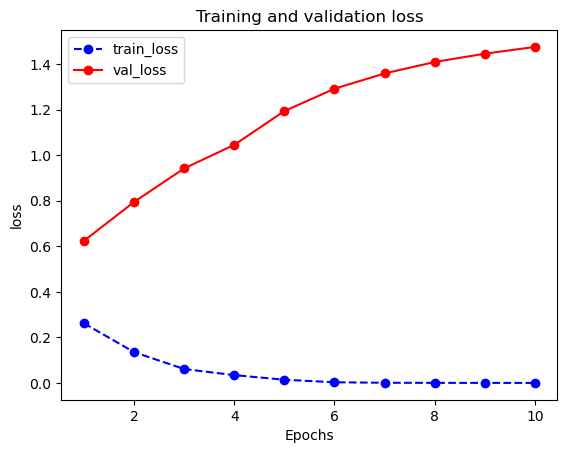

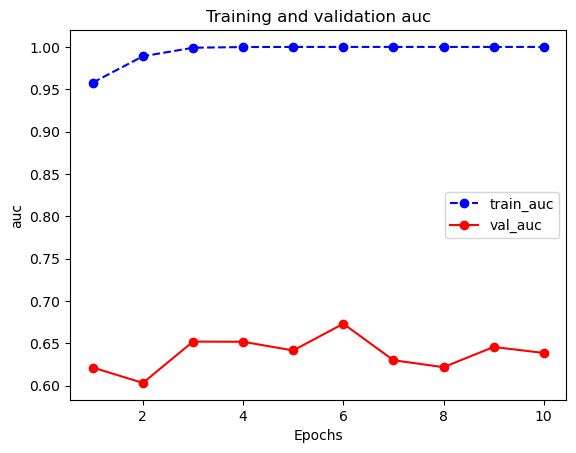

In [23]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# 观察损失和准确率的变化
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"auc")

In [24]:
# 预测
y_pred_probs = model(torch.tensor(test_x).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [25]:
y_pred.data

tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
      